In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def data_clean(df, feature, m):
    count = df[feature].value_counts()
    df = df[df[feature].isin(count[count > m].index)]
    return df

def data_clean_sum(df,features,m):
    fil = df.ProductId.value_counts()
    fil2 = df.UserId.value_counts()
    df['#Proudcts'] = df.ProductId.apply(lambda x: fil[x])
    df['#Users'] = df.UserId.apply(lambda x: fil2[x])
    while (df.ProductId.value_counts(ascending=True)[0]) < m or \
    (df.UserId.value_counts(ascending=True)[0] < m):
        df = data_clean(df,features[0],m)
        df = data_clean(df,features[1],m)
    return df

# check if it is correct

def data():
    print('loading data...')
    df = pd.read_csv('Reviews.csv')
    df['datetime'] = pd.to_datetime(df.Time, unit='s')
    raw_data = data_clean_sum(df, ['ProductId', 'UserId'], 10)
    # find X,and y
    raw_data['uid'] = pd.factorize(raw_data['UserId'])[0]
    raw_data['pid'] = pd.factorize(raw_data['ProductId'])[0]
    sc = MinMaxScaler()
    raw_data['time']=sc.fit_transform(raw_data['Time'].values.reshape(-1,1))
    raw_data['nuser']=sc.fit_transform(raw_data['#Users'].values.reshape(-1,1))
    raw_data['nproduct']=sc.fit_transform(raw_data['#Proudcts'].values.reshape(-1,1))
    # Sepreate the features into three groups
    X1 = raw_data.loc[:,['uid','pid']]
    X2 = raw_data.loc[:,['uid','pid','time']]
    X3 = raw_data.loc[:,['uid','pid','time','nuser','nproduct']]
    y = raw_data.Score
    # train_test split
    X1_train,X1_test,y_train,y_test = train_test_split(X1,y,test_size=0.3,random_state=2017)
    X2_train,X2_test,y_train,y_test = train_test_split(X2,y,test_size=0.3,random_state=2017)
    X3_train,X3_test,y_train,y_test = train_test_split(X3,y,test_size=0.3,random_state=2017)
    train = np.array(X1_train.join(y_train))
    test = np.array(X1_test.join(y_test))
    # got the productId to pid index
    pid2PID = raw_data.ProductId.unique()

    data_mixed = X1.join(y)
    total_p = data_mixed['pid'].unique().shape[0]
    total_u = data_mixed['uid'].unique().shape[0]
    # make the user-item table
    table = np.zeros([total_u,total_p])
    z = np.array(data_mixed)
    for line in z:
        u,p,s = line
        if table[u][p] < s:
            table[u][p] = s #if some one score a single thing several times
    print('the table\'s shape is:' )
    print(table.shape)
    return z, total_u,total_p,pid2PID,train,test,table,raw_data

z, total_u,total_p,pid2PID,train,test,table,raw_data = data()

loading data...


D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


the table's shape is:
(3666, 1102)


# Evaluate 

In [14]:
from sklearn.metrics import mean_squared_error
def caculate_mse(x):
    MSE1=[]
    MSE2=[]
    for line in train:
        u,p,s = line
        MSE1.append(s)
        MSE2.append(x[u,p])
    MSE_in_sample = mean_squared_error(MSE1,MSE2)
    MSE3=[]
    MSE4 = []
    for line in test:
        u,p,s = line
        MSE3.append(s)
        MSE4.append(x[u,p])
    MSE_out_sample = mean_squared_error(MSE3,MSE4)
    print('the in sample MSE = {} \nthe out sample MSE = {}'.format(MSE_in_sample,MSE_out_sample))
    return MSE_in_sample,MSE_out_sample


def draw_mse(method,maxIter):
    import time
    c = []
    d = []
    timetime = []
    for i in [1,2,5,7,10,20,50,70,100]:
        tic = time.time()
        data = method(factors=i,maxIter=maxIter)
        a,b = caculate_mse(data)
        c.append(a)
        d.append(b)
        toc = time.time()
        timetime.append(toc-tic)
    aa = [1, 2, 5, 7, 10, 20, 50, 70, 100]
    for i in range(len(timetime)):

        print('latent factors = {}, time = {}'.format(aa[i],timetime[i]))
    plt.figure()
    plt.plot(aa,c,label = 'in_sample_MSE')
    plt.plot(aa,d,label = 'out_sample_MSE')
    plt.xticks([1,2,5,7,10,20,50,70,100])
    plt.legend()
    plt.show()
    return 0


# Vizualization

In [21]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



def drawcm(y_pred,y_test =test ,title=''):
    print('caculating cm..')
    y1=[]
    y2=[]
    for line in y_test:
        u,p,s = line
        y1.append(s)
        y2.append(y_pred[u,p])
    temp1 = []
    temp2 = []
    for i in range(len(y1)):
        if np.array(y1)[i] >= 4:
            temp1.append(1)
        elif np.array(y1)[i] <= 2:
            temp1.append(0)
        else:
            temp1.append(0)
        if y2[i] >= 4:
            temp2.append(1)
        elif y2[i] <= 2:
            temp2.append(0)
        else:
            temp2.append(0)
    cm = confusion_matrix(temp1,temp2)
    plt.figure()
    plot_confusion_matrix(cm, classes=['not','recommand'], normalize=True,
                          title=title)
    plt.show()

# Matrix Factoriztion

In [22]:
def MF1(data=z, factors=30, maxIter=100, LRate=0.02, GD_end=1e-3, plot=False):
    # initial the latent matrix for user and item
    P = np.random.rand(total_u, factors) / 3
    Q = np.random.rand(total_p, factors) / 3
    # initial y as the history of loss
    y = []
    # initial the iteration and last loss
    iteration = 0
    last_loss = 0
    while iteration < maxIter:
        loss = 0
        for i in range(data.shape[0]):
            # get the uid,pid and the score from every line
            u, p, s = data[i]
            # calculate the error
            error = s - np.dot(P[u], Q[p])
            # calculate the loss function
            # avoid loss become to large, scale to 1/50
            loss += error ** 2 / 50
            # update the parameter according to the gradient descent
            pp = P[u]
            qq = Q[p]
            P[u] += LRate * error * qq
            Q[p] += LRate * error * pp
        iteration += 1
        y.append(loss)
        delta_loss = last_loss - loss
        print('iter = {}, loss = {}, delta_loss = {}, LR = {}'.format(iteration, loss, delta_loss, LRate))
        # update the learn rate to make sure it will converge
        if abs(last_loss) > abs(loss):
            LRate *= 1.05
        else:
            LRate *= 0.5
        # When converge, stop the gradient descend
        if abs(delta_loss) < abs(GD_end):
            print('the diff in loss is {}, so the GD stops'.format(delta_loss))
            break
        last_loss = loss
    if plot:
        plt.plot(y)
        plt.show()
    return P.dot(Q.T)

iter = 1, loss = 3307.6040945337645, delta_loss = -3307.6040945337645, LR = 0.02
iter = 2, loss = 958.3536108483506, delta_loss = 2349.250483685414, LR = 0.01
iter = 3, loss = 622.6404090850418, delta_loss = 335.7132017633088, LR = 0.0105
iter = 4, loss = 574.5033977849312, delta_loss = 48.13701130011066, LR = 0.011025000000000002
iter = 5, loss = 540.175395029607, delta_loss = 34.32800275532418, LR = 0.011576250000000003
iter = 6, loss = 505.2999486787047, delta_loss = 34.87544635090228, LR = 0.012155062500000004
iter = 7, loss = 466.1450380200264, delta_loss = 39.15491065867832, LR = 0.012762815625000005
iter = 8, loss = 423.23412207529935, delta_loss = 42.91091594472704, LR = 0.013400956406250006
iter = 9, loss = 379.10593716964894, delta_loss = 44.128184905650414, LR = 0.014071004226562506
iter = 10, loss = 336.34700178002436, delta_loss = 42.75893538962458, LR = 0.014774554437890632
iter = 11, loss = 296.558671979763, delta_loss = 39.78832980026135, LR = 0.015513282159785164
iter 

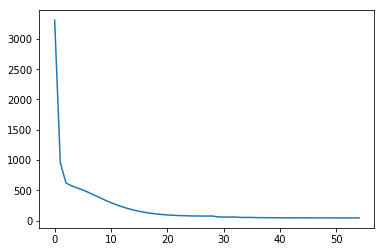

the in sample MSE = 0.03538197029440516 
the out sample MSE = 0.033854052411442306
caculating cm..
Normalized confusion matrix
[[0.98999183 0.01000817]
 [0.14528669 0.85471331]]


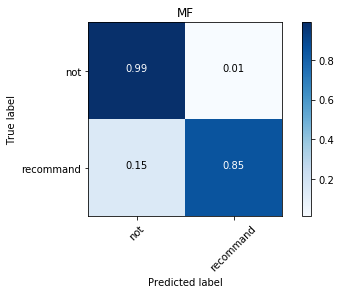

In [23]:
result = MF1(factors=30, maxIter=100, LRate=0.02, GD_end=1e-3, plot=1)
caculate_mse(result)
drawcm(result,title='MF')

# Probalistic Matrix Factorization

In [24]:
def PMF(data=z, factors=30, maxIter=100, LRate=0.02, GD_end=1e-3, regU = 0.01 ,regI = 0.01 ,plot=False):
    P = np.random.rand(total_u, factors) / 3
    Q = np.random.rand(total_p, factors) / 3
    y = []
    iteration = 0
    last_loss = 100
    while iteration < maxIter:
        loss = 0
        for i in range(data.shape[0]):
            u, p, s = data[i]
            error = s - np.dot(P[u], Q[p])
            loss += error ** 2/50
            pp = P[u]
            qq = Q[p]
            P[u] += LRate *  (error * qq - regU*pp)
            Q[p] += LRate * (error * pp - regI * qq)
        loss += regU*(P*P).sum() +regI*(Q*Q).sum()
        iteration += 1
        y.append(loss)
        delta_loss = last_loss - loss
        print('iter = {}, loss = {}, delta_loss = {}, LR = {}'.format(iteration, loss, delta_loss, LRate))
        if abs(last_loss) > abs(loss):
            LRate *= 1.05
        else:
            LRate *= 0.5

        if abs(delta_loss) < abs(GD_end):
            print('the diff in loss is {}, so the GD stops'.format(delta_loss))
            break
        last_loss = loss
    if plot:
        plt.plot(y)
        plt.show()
    return P.dot(Q.T)

iter = 1, loss = 3478.221389494684, delta_loss = -3378.221389494684, LR = 0.02
iter = 2, loss = 1108.0040348018013, delta_loss = 2370.2173546928825, LR = 0.01
iter = 3, loss = 790.2390126450848, delta_loss = 317.76502215671644, LR = 0.0105
iter = 4, loss = 746.1608275651575, delta_loss = 44.078185079927266, LR = 0.011025000000000002
iter = 5, loss = 716.1371258332301, delta_loss = 30.023701731927417, LR = 0.011576250000000003
iter = 6, loss = 686.2873065521387, delta_loss = 29.849819281091413, LR = 0.012155062500000004
iter = 7, loss = 652.5705911302925, delta_loss = 33.716715421846175, LR = 0.012762815625000005
iter = 8, loss = 614.8501799168087, delta_loss = 37.720411213483885, LR = 0.013400956406250006
iter = 9, loss = 575.1937299898215, delta_loss = 39.65644992698719, LR = 0.014071004226562506
iter = 10, loss = 535.9220935243707, delta_loss = 39.2716364654508, LR = 0.014774554437890632
iter = 11, loss = 498.6220418098145, delta_loss = 37.30005171455616, LR = 0.015513282159785164
it

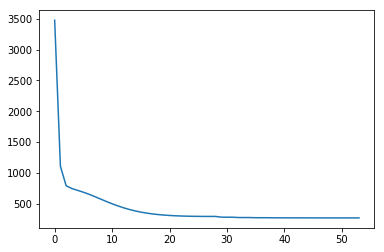

the in sample MSE = 0.037865655566060974 
the out sample MSE = 0.03627835707546837
caculating cm..
Normalized confusion matrix
[[0.99162582 0.00837418]
 [0.19380814 0.80619186]]


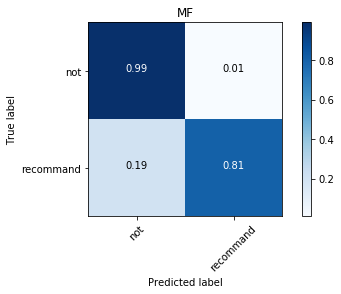

In [25]:
result =PMF( factors=30, maxIter=100, LRate=0.02, GD_end=1e-3, plot=1)
caculate_mse(result)
drawcm(result,title='MF')

# SVD

In [34]:
from scipy.sparse.linalg import svds
from numpy import linalg as la
def svdrec(table = table, factors= 150):
    UI = np.matrix(table)
    # ui_df = pd.DataFrame(UI,index=table.index, columns=table.columns)
    user_ratings_mean = np.mean(UI,axis=0)
    user_ratings_mean = user_ratings_mean.reshape(1,-1)
    UI_demeaned=UI-user_ratings_mean
    U,sigma,Vt=svds(UI_demeaned,factors)
    sigma = np.diag(sigma)
    pred_mat = np.dot(np.dot(U,sigma),Vt) + user_ratings_mean
    sc=MinMaxScaler(feature_range = (1,5))
    pred_mat = sc.fit_transform(pred_mat)
    # prediction_df=pd.DataFrame(pred_mat,index=table.index,columns=table.columns)
    return pred_mat


the in sample MSE = 0.3982335596954266 
the out sample MSE = 0.39813597209585766
caculating cm..
Normalized confusion matrix
[[0.96364379 0.03635621]
 [0.15361655 0.84638345]]


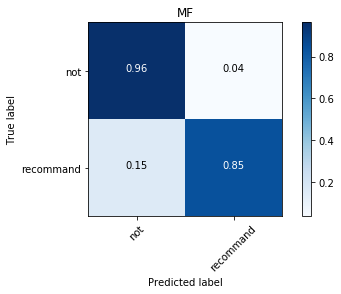

In [35]:
result = svdrec()
caculate_mse(result)
drawcm(result,title='MF')

# Random Forest

In [48]:
from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.ensemble import *
def rf():
    # find X,and y
    raw_data['uid'] = pd.factorize(raw_data['UserId'])[0]
    raw_data['pid'] = pd.factorize(raw_data['ProductId'])[0]
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler()
    raw_data['time']=sc.fit_transform(raw_data['Time'].values.reshape(-1,1))
    raw_data['nuser']=sc.fit_transform(raw_data['#Users'].values.reshape(-1,1))
    raw_data['nproduct']=sc.fit_transform(raw_data['#Proudcts'].values.reshape(-1,1))

    X1 = raw_data.loc[:,['uid','pid']]
    X2 = raw_data.loc[:,['uid','pid','time']]
    X3 = raw_data.loc[:,['uid','pid','time','nuser','nproduct']]
    y = raw_data.Score

    from sklearn.model_selection import train_test_split
    X1_train,X1_test,y_train,y_test = train_test_split(X1,y,test_size=0.3,random_state=2017)
    X2_train,X2_test,y_train,y_test = train_test_split(X2,y,test_size=0.3,random_state=2017)
    X3_train,X3_test,y_train,y_test = train_test_split(X3,y,test_size=0.3,random_state=2017)
    a=RandomForestRegressor()
    a.fit(X3_train,y_train)
    y3 = a.predict(X3_test)
    sc = MinMaxScaler(feature_range=(1,5))
    c = mean_squared_error(y_train,a.predict(X3_train)), mean_squared_error(y_test,sc.fit_transform(y3.reshape(-1,1)))
    b = mean_squared_error(y_test,y3)
    print('train MSE is {}, test MSE is {}'.format(c,b))

    c3 = y3>=4
    t = y_test>=4
    print('accuracy of recommandtion:')
    print(accuracy_score(t,c3))
    c31 = y3<=1
    t1 = y_test<=1
    print('accuracy of not recommandtion:')
    print(accuracy_score(t1,c31))
    y_pred3 = []
    y_test3 = []
    for i in range(y3.shape[0]):
        if y3[i]>=4:
            y_pred3.append(1)
        elif y3[i]<4:
            y_pred3.append(0)
        # else:
            # y_pred3.append(1)

    for j in range(y3.shape[0]):
        if np.array(y_test)[j]>=4:
            y_test3.append(1)
        elif np.array(y_test)[j]<4:
            y_test3.append(0)
        # else:
            # y_test3.append(1)
    import itertools
    import matplotlib.pyplot as plt
    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    class_names = ['not recommand','recommand']
    cnf_matrix = confusion_matrix(y_test3,y_pred3)
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='rf')


    plt.show()
    return a

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


train MSE is (0.07146856355845015, 0.3393944189104509), test MSE is 0.3393944189104509
accuracy of recommandtion:
0.8786654232721998
accuracy of not recommandtion:
0.9796394156046005
Normalized confusion matrix
[[0.89 0.11]
 [0.13 0.87]]


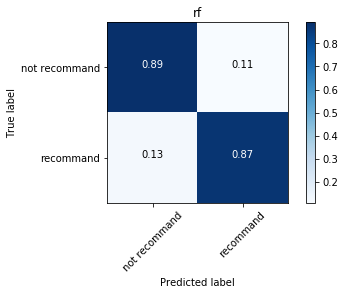

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [49]:
rf()